
=== Обучаем модель с learning rate = 0.001 ===
LR=0.001 | Epoch 1/10 | TrainLoss=1.3234 | TestAcc=87.43%
LR=0.001 | Epoch 2/10 | TrainLoss=0.5418 | TestAcc=90.44%
LR=0.001 | Epoch 3/10 | TrainLoss=0.4277 | TestAcc=91.62%
LR=0.001 | Epoch 4/10 | TrainLoss=0.3674 | TestAcc=92.25%
LR=0.001 | Epoch 5/10 | TrainLoss=0.3325 | TestAcc=93.21%
LR=0.001 | Epoch 6/10 | TrainLoss=0.3025 | TestAcc=93.72%
LR=0.001 | Epoch 7/10 | TrainLoss=0.2800 | TestAcc=93.99%
LR=0.001 | Epoch 8/10 | TrainLoss=0.2595 | TestAcc=94.40%
LR=0.001 | Epoch 9/10 | TrainLoss=0.2427 | TestAcc=94.79%
LR=0.001 | Epoch 10/10 | TrainLoss=0.2291 | TestAcc=95.07%
⏱ Время обучения: 248.6 сек


=== Обучаем модель с learning rate = 0.01 ===
LR=0.010 | Epoch 1/10 | TrainLoss=0.5122 | TestAcc=94.37%
LR=0.010 | Epoch 2/10 | TrainLoss=0.2112 | TestAcc=96.26%
LR=0.010 | Epoch 3/10 | TrainLoss=0.1572 | TestAcc=96.98%
LR=0.010 | Epoch 4/10 | TrainLoss=0.1308 | TestAcc=97.20%
LR=0.010 | Epoch 5/10 | TrainLoss=0.1149 | TestAcc=97.51%
LR=0.

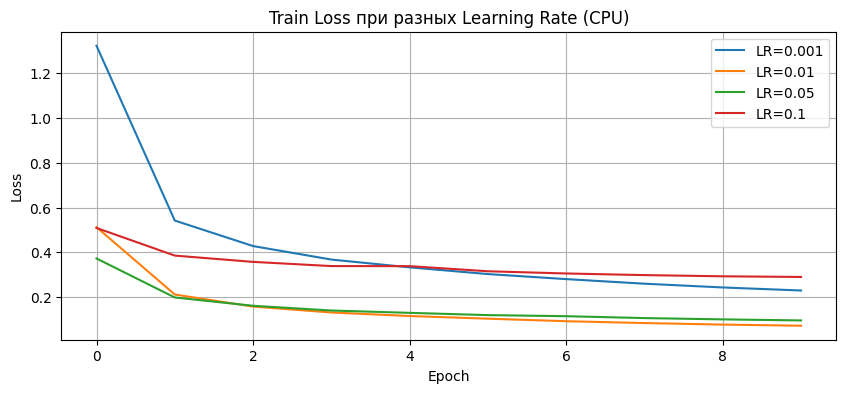

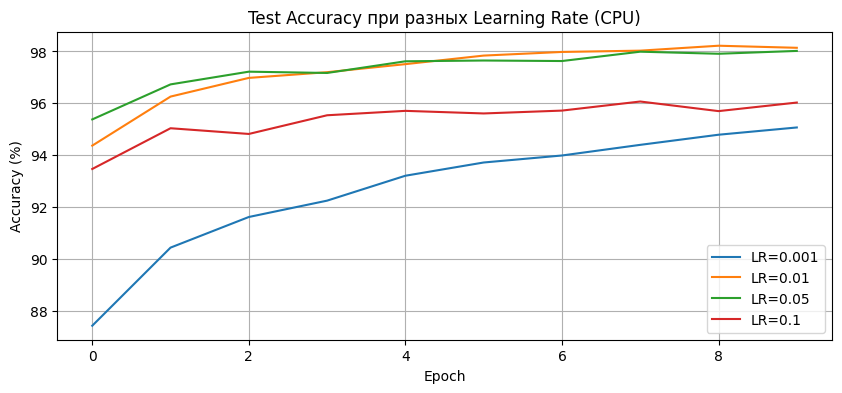


📊 Результаты по скоростям обучения:
LR=0.001 | Лучшая точность: 95.07% | Время: 248.6 сек.
LR=0.010 | Лучшая точность: 98.22% | Время: 248.5 сек.
LR=0.050 | Лучшая точность: 98.02% | Время: 248.0 сек.
LR=0.100 | Лучшая точность: 96.07% | Время: 246.3 сек.


In [ ]:
# ============================================================
# Эксперимент: подбор скорости обучения (learning rate)
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np, random, time, matplotlib.pyplot as plt

# -----------------------------
# 1. Фиксируем seed
# -----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(42)

# -----------------------------
# 2. Загрузка MNIST
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST("data", train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

# -----------------------------
# 3. Модель
# -----------------------------
class SmallDropoutNet(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(512, 512)
        self.drop2 = nn.Dropout(p)
        self.fc3 = nn.Linear(512, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)

# -----------------------------
# 4. Функция обучения
# -----------------------------
def train_and_eval(model, lr=0.01, epochs=10, momentum=0.9):
    device = torch.device("cpu")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_loss, test_acc = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss.append(total_loss / len(train_loader))

        # тест
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = 100 * correct / total
        test_acc.append(acc)
        print(f"LR={lr:.3f} | Epoch {epoch+1}/{epochs} | TrainLoss={train_loss[-1]:.4f} | TestAcc={acc:.2f}%")
    return train_loss, test_acc

# -----------------------------
# 5. Проверяем разные learning rate
# -----------------------------
learning_rates = [0.001, 0.01, 0.05, 0.1]
results = {}

for lr in learning_rates:
    print(f"\n=== Обучаем модель с learning rate = {lr} ===")
    model = SmallDropoutNet(p=0.5)
    t0 = time.time()
    losses, accs = train_and_eval(model, lr=lr, epochs=10)
    elapsed = time.time() - t0
    results[lr] = {"loss": losses, "acc": accs, "time": elapsed}
    print(f"⏱ Время обучения: {elapsed:.1f} сек\n")

# -----------------------------
# 6. Визуализация
# -----------------------------
plt.figure(figsize=(10,4))
for lr, r in results.items():
    plt.plot(r["loss"], label=f"LR={lr}")
plt.title("Train Loss при разных Learning Rate (CPU)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
for lr, r in results.items():
    plt.plot(r["acc"], label=f"LR={lr}")
plt.title("Test Accuracy при разных Learning Rate (CPU)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# 7. Итоговая таблица скоростей
# -----------------------------
print("\n📊 Результаты по скоростям обучения:")
for lr, r in results.items():
    best_acc = max(r["acc"])
    print(f"LR={lr:.3f} | Лучшая точность: {best_acc:.2f}% | Время: {r['time']:.1f} сек.")



=== Обучаем модель: L2 ===
Epoch 01/10 | Loss=0.3943 | TestAcc=94.98%
Epoch 02/10 | Loss=0.1403 | TestAcc=96.52%
Epoch 03/10 | Loss=0.0950 | TestAcc=97.08%
Epoch 04/10 | Loss=0.0688 | TestAcc=97.67%
Epoch 05/10 | Loss=0.0526 | TestAcc=97.83%
Epoch 06/10 | Loss=0.0413 | TestAcc=97.78%
Epoch 07/10 | Loss=0.0318 | TestAcc=97.88%
Epoch 08/10 | Loss=0.0248 | TestAcc=98.03%
Epoch 09/10 | Loss=0.0195 | TestAcc=97.93%
Epoch 10/10 | Loss=0.0160 | TestAcc=98.18%

=== Обучаем модель: Dropout ===
Epoch 01/10 | Loss=0.5051 | TestAcc=94.54%
Epoch 02/10 | Loss=0.2102 | TestAcc=96.39%
Epoch 03/10 | Loss=0.1606 | TestAcc=96.97%
Epoch 04/10 | Loss=0.1322 | TestAcc=97.32%
Epoch 05/10 | Loss=0.1146 | TestAcc=97.70%
Epoch 06/10 | Loss=0.1017 | TestAcc=97.65%
Epoch 07/10 | Loss=0.0903 | TestAcc=98.03%
Epoch 08/10 | Loss=0.0840 | TestAcc=97.96%
Epoch 09/10 | Loss=0.0771 | TestAcc=98.11%
Epoch 10/10 | Loss=0.0686 | TestAcc=97.93%

=== Обучаем модель: L2+Dropout ===
Epoch 01/10 | Loss=0.5064 | TestAcc=94.59%


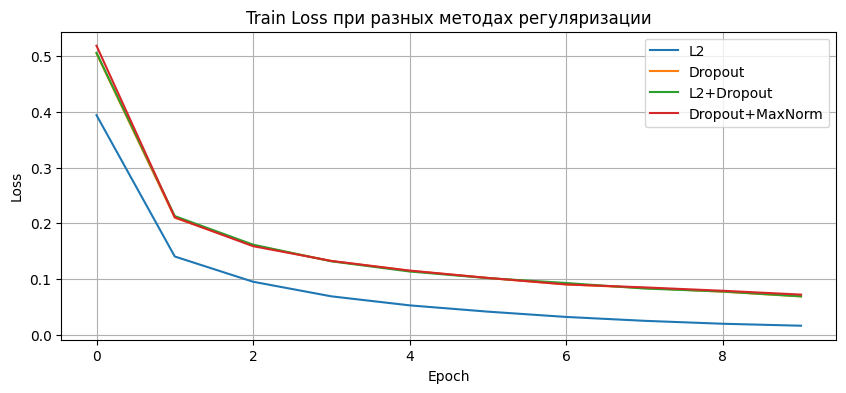

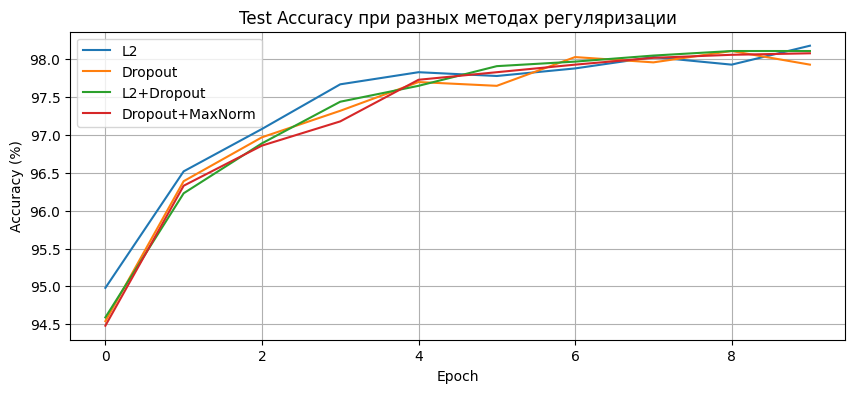


📊 Итоговая точность:
L2                 | MaxAcc=98.18% | Время=215.1 сек.
Dropout            | MaxAcc=98.11% | Время=230.0 сек.
L2+Dropout         | MaxAcc=98.11% | Время=233.8 сек.
Dropout+MaxNorm    | MaxAcc=98.08% | Время=235.8 сек.


In [ ]:
# ============================================================
# Сравнение методов регуляризации (на CPU)
# ============================================================
import torch, time, numpy as np, random, matplotlib.pyplot as plt
import torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------
# 1. Фиксируем seed
# -----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(42)

# -----------------------------
# 2. Данные
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST("data", train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

# -----------------------------
# 3. Модель
# -----------------------------
class SmallNet(nn.Module):
    def __init__(self, dropout=False, p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(512, 512)
        self.drop2 = nn.Dropout(p)
        self.fc3 = nn.Linear(512, 10)
        self.use_drop = dropout
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        if self.use_drop: x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        if self.use_drop: x = self.drop2(x)
        return self.fc3(x)

# -----------------------------
# 4. Обучение + тест
# -----------------------------
def train_and_eval(model, epochs=20, lr=0.01, momentum=0.9,
                   l2_weight=0.0, use_maxnorm=False, c=3.0):
    device = torch.device("cpu")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=l2_weight)
    criterion = nn.CrossEntropyLoss()

    train_loss, test_acc = [], []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()

            # Max-Norm constraint (если активен)
            if use_maxnorm:
                for p in model.parameters():
                    if p.dim() == 2:
                        nn.utils.clip_grad_norm_(p, c)

            optimizer.step()
            loss_sum += loss.item()
        train_loss.append(loss_sum / len(train_loader))

        # тест
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = 100 * correct / total
        test_acc.append(acc)
        print(f"Epoch {epoch+1:02d}/{epochs} | Loss={train_loss[-1]:.4f} | TestAcc={acc:.2f}%")
    return train_loss, test_acc

# -----------------------------
# 5. Запускаем все эксперименты
# -----------------------------
configs = {
    "L2": dict(dropout=False, l2_weight=1e-4, use_maxnorm=False),
    "Dropout": dict(dropout=True, l2_weight=0.0, use_maxnorm=False),
    "L2+Dropout": dict(dropout=True, l2_weight=1e-4, use_maxnorm=False),
    "Dropout+MaxNorm": dict(dropout=True, l2_weight=0.0, use_maxnorm=True)
}

results = {}
for name, cfg in configs.items():
    print(f"\n=== Обучаем модель: {name} ===")
    model = SmallNet(dropout=cfg["dropout"])
    t0 = time.time()
    loss, acc = train_and_eval(
        model, lr=0.01, epochs=10,
        l2_weight=cfg["l2_weight"],
        use_maxnorm=cfg["use_maxnorm"]
    )
    results[name] = {"loss": loss, "acc": acc, "time": time.time()-t0}

# -----------------------------
# 6. Визуализация
# -----------------------------
plt.figure(figsize=(10,4))
for name, r in results.items():
    plt.plot(r["loss"], label=name)
plt.title("Train Loss при разных методах регуляризации")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
for name, r in results.items():
    plt.plot(r["acc"], label=name)
plt.title("Test Accuracy при разных методах регуляризации")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# 7. Таблица результатов
# -----------------------------
print("\n📊 Итоговая точность:")
for name, r in results.items():
    print(f"{name:18s} | MaxAcc={max(r['acc']):.2f}% | Время={r['time']:.1f} сек.")



=== Обучаем модель с Dropout p=0.0 ===
p=0.0 | Epoch 01/10 | TrainLoss=0.3942 | TestAcc=94.94%
p=0.0 | Epoch 02/10 | TrainLoss=0.1399 | TestAcc=96.51%
p=0.0 | Epoch 03/10 | TrainLoss=0.0943 | TestAcc=97.15%
p=0.0 | Epoch 04/10 | TrainLoss=0.0680 | TestAcc=97.60%
p=0.0 | Epoch 05/10 | TrainLoss=0.0517 | TestAcc=97.75%
p=0.0 | Epoch 06/10 | TrainLoss=0.0403 | TestAcc=97.70%
p=0.0 | Epoch 07/10 | TrainLoss=0.0308 | TestAcc=97.86%
p=0.0 | Epoch 08/10 | TrainLoss=0.0238 | TestAcc=98.05%
p=0.0 | Epoch 09/10 | TrainLoss=0.0185 | TestAcc=97.98%
p=0.0 | Epoch 10/10 | TrainLoss=0.0148 | TestAcc=98.16%

=== Обучаем модель с Dropout p=0.2 ===
p=0.2 | Epoch 01/10 | TrainLoss=0.4267 | TestAcc=94.78%
p=0.2 | Epoch 02/10 | TrainLoss=0.1586 | TestAcc=96.55%
p=0.2 | Epoch 03/10 | TrainLoss=0.1111 | TestAcc=97.29%
p=0.2 | Epoch 04/10 | TrainLoss=0.0850 | TestAcc=97.51%
p=0.2 | Epoch 05/10 | TrainLoss=0.0683 | TestAcc=97.98%
p=0.2 | Epoch 06/10 | TrainLoss=0.0581 | TestAcc=98.01%
p=0.2 | Epoch 07/10 | Tr

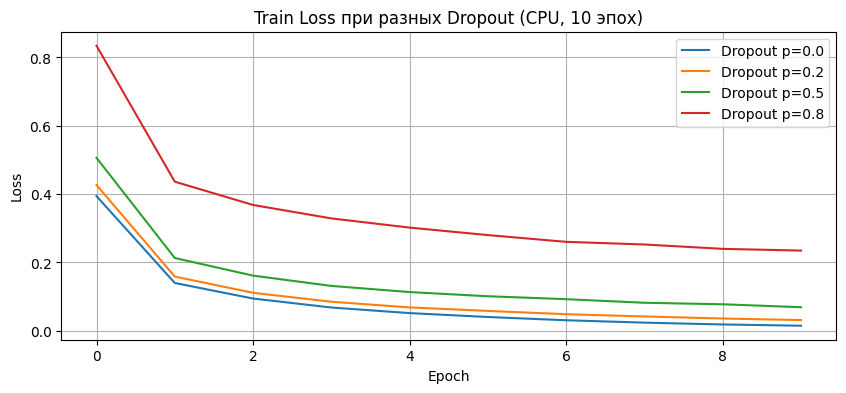

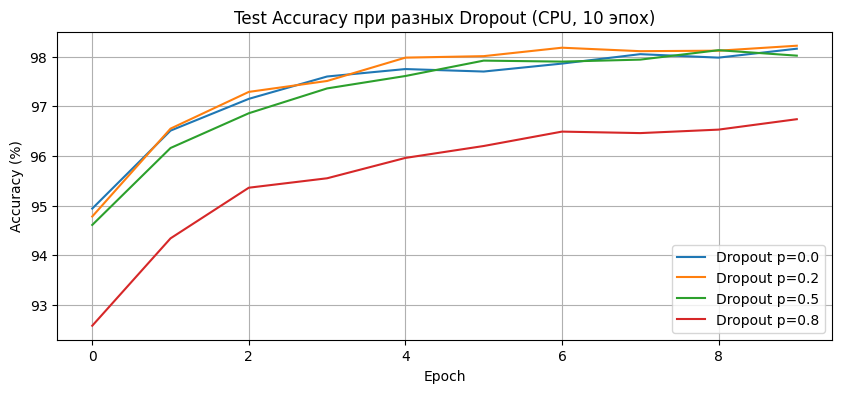


📊 Итоги по dropout rate (10 эпох):
p=0.0 | MaxAcc=98.16% | Время=211.2 сек.
p=0.2 | MaxAcc=98.22% | Время=227.2 сек.
p=0.5 | MaxAcc=98.13% | Время=230.0 сек.
p=0.8 | MaxAcc=96.74% | Время=227.0 сек.


In [ ]:
# ============================================================
# Эксперимент: влияние dropout rate на обучение (10 эпох)
# ============================================================
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np, random, time, matplotlib.pyplot as plt

# -----------------------------
# 1. Фиксируем seed
# -----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(42)

# -----------------------------
# 2. Загружаем MNIST
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST("data", train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

# -----------------------------
# 3. Модель
# -----------------------------
class SmallDropoutNet(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(512, 512)
        self.drop2 = nn.Dropout(p)
        self.fc3 = nn.Linear(512, 10)
        self.p = p
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)

# -----------------------------
# 4. Функция обучения
# -----------------------------
def train_and_eval(model, lr=0.01, momentum=0.9, epochs=10):
    device = torch.device("cpu")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_loss, test_acc = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss.append(total_loss / len(train_loader))

        # тест
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = 100 * correct / total
        test_acc.append(acc)
        print(f"p={model.p} | Epoch {epoch+1:02d}/{epochs} | TrainLoss={train_loss[-1]:.4f} | TestAcc={acc:.2f}%")
    return train_loss, test_acc

# -----------------------------
# 5. Проверяем разные dropout значения
# -----------------------------
dropout_values = [0.0, 0.2, 0.5, 0.8]
results = {}

for p in dropout_values:
    print(f"\n=== Обучаем модель с Dropout p={p} ===")
    model = SmallDropoutNet(p=p)
    t0 = time.time()
    loss, acc = train_and_eval(model, lr=0.01, epochs=10)
    results[p] = {"loss": loss, "acc": acc, "time": time.time()-t0}

# -----------------------------
# 6. Визуализация
# -----------------------------
plt.figure(figsize=(10,4))
for p, r in results.items():
    plt.plot(r["loss"], label=f"Dropout p={p}")
plt.title("Train Loss при разных Dropout (CPU, 10 эпох)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
for p, r in results.items():
    plt.plot(r["acc"], label=f"Dropout p={p}")
plt.title("Test Accuracy при разных Dropout (CPU, 10 эпох)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# 7. Таблица итогов
# -----------------------------
print("\n📊 Итоги по dropout rate (10 эпох):")
for p, r in results.items():
    print(f"p={p:.1f} | MaxAcc={max(r['acc']):.2f}% | Время={r['time']:.1f} сек.")



=== Обучаем с 500 обучающими примерами ===
Epoch 01/10 | TestAcc=21.09%
Epoch 02/10 | TestAcc=31.69%
Epoch 03/10 | TestAcc=36.93%
Epoch 04/10 | TestAcc=46.89%
Epoch 05/10 | TestAcc=53.39%
Epoch 06/10 | TestAcc=63.16%
Epoch 07/10 | TestAcc=70.76%
Epoch 08/10 | TestAcc=74.80%
Epoch 09/10 | TestAcc=78.79%
Epoch 10/10 | TestAcc=79.98%
✅ 500 примеров | Лучшая точность: 79.98% | Время: 33.6 сек.

=== Обучаем с 10000 обучающими примерами ===
Epoch 01/10 | TestAcc=87.70%
Epoch 02/10 | TestAcc=90.44%
Epoch 03/10 | TestAcc=92.57%
Epoch 04/10 | TestAcc=93.32%
Epoch 05/10 | TestAcc=94.04%
Epoch 06/10 | TestAcc=94.22%
Epoch 07/10 | TestAcc=94.49%
Epoch 08/10 | TestAcc=95.02%
Epoch 09/10 | TestAcc=95.19%
Epoch 10/10 | TestAcc=95.45%
✅ 10000 примеров | Лучшая точность: 95.45% | Время: 62.0 сек.

=== Обучаем с 30000 обучающими примерами ===
Epoch 01/10 | TestAcc=92.34%
Epoch 02/10 | TestAcc=94.68%
Epoch 03/10 | TestAcc=95.39%
Epoch 04/10 | TestAcc=96.23%
Epoch 05/10 | TestAcc=96.55%
Epoch 06/10 | Tes

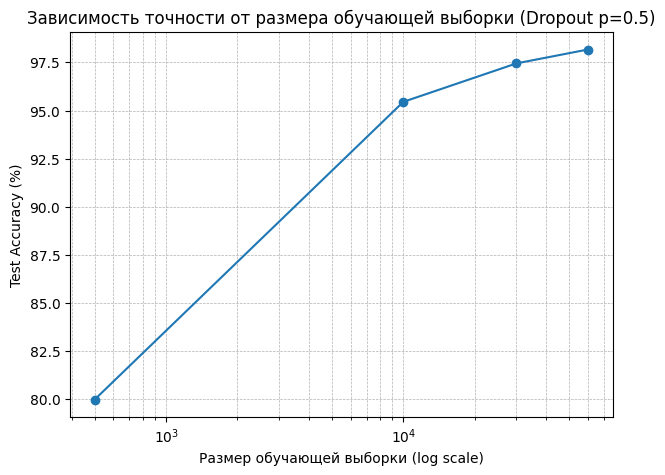


📊 Итог:
Train size=   500 | Max Test Accuracy=79.98% | Time=33.6 сек.
Train size= 10000 | Max Test Accuracy=95.45% | Time=62.0 сек.
Train size= 30000 | Max Test Accuracy=97.45% | Time=133.8 сек.
Train size= 60000 | Max Test Accuracy=98.17% | Time=241.8 сек.


In [ ]:
# ============================================================
# Эксперимент: влияние размера обучающей выборки при Dropout p=0.5
# ============================================================
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np, random, time, matplotlib.pyplot as plt

# -----------------------------
# 1. Seed
# -----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(42)

# -----------------------------
# 2. Данные
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
full_train = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST("data", train=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# -----------------------------
# 3. Модель
# -----------------------------
class SmallDropoutNet(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(512, 512)
        self.drop2 = nn.Dropout(p)
        self.fc3 = nn.Linear(512, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)

# -----------------------------
# 4. Функция обучения
# -----------------------------
def train_and_eval(model, train_loader, epochs=10, lr=0.01, momentum=0.9):
    device = torch.device("cpu")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    test_acc = []
    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = 100 * correct / total
        test_acc.append(acc)
        print(f"Epoch {epoch+1:02d}/{epochs} | TestAcc={acc:.2f}%")
    return max(test_acc)

# -----------------------------
# 5. Проверяем разные размеры обучающей выборки
# -----------------------------
train_sizes = [500, 10_000, 30_000, 60_000]
results = {}

for size in train_sizes:
    print(f"\n=== Обучаем с {size} обучающими примерами ===")
    subset_indices = np.random.choice(len(full_train), size=size, replace=False)
    train_subset = Subset(full_train, subset_indices)
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

    model = SmallDropoutNet(p=0.5)
    t0 = time.time()
    best_acc = train_and_eval(model, train_loader, epochs=10)
    elapsed = time.time() - t0
    results[size] = {"acc": best_acc, "time": elapsed}
    print(f"✅ {size} примеров | Лучшая точность: {best_acc:.2f}% | Время: {elapsed:.1f} сек.")

# -----------------------------
# 6. Визуализация
# -----------------------------
sizes = list(results.keys())
accs = [results[s]["acc"] for s in sizes]

plt.figure(figsize=(7,5))
plt.plot(sizes, accs, marker="o")
plt.xscale("log")
plt.title("Зависимость точности от размера обучающей выборки (Dropout p=0.5)")
plt.xlabel("Размер обучающей выборки (log scale)")
plt.ylabel("Test Accuracy (%)")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

print("\n📊 Итог:")
for s, r in results.items():
    print(f"Train size={s:6d} | Max Test Accuracy={r['acc']:.2f}% | Time={r['time']:.1f} сек.")


🚀 Обучаем модель (Dropout p=0.2, lr=0.01, 10 эпох)...
Epoch 01/10 | TrainLoss=0.4255 | TestAcc=95.10%
Epoch 02/10 | TrainLoss=0.1574 | TestAcc=96.58%
Epoch 03/10 | TrainLoss=0.1111 | TestAcc=97.19%
Epoch 04/10 | TrainLoss=0.0859 | TestAcc=97.61%
Epoch 05/10 | TrainLoss=0.0716 | TestAcc=97.85%
Epoch 06/10 | TrainLoss=0.0579 | TestAcc=97.89%
Epoch 07/10 | TrainLoss=0.0487 | TestAcc=98.13%
Epoch 08/10 | TrainLoss=0.0431 | TestAcc=98.10%
Epoch 09/10 | TrainLoss=0.0375 | TestAcc=98.21%
Epoch 10/10 | TrainLoss=0.0314 | TestAcc=98.16%

✅ Финальная точность: 98.21% | Время обучения: 230.4 сек.


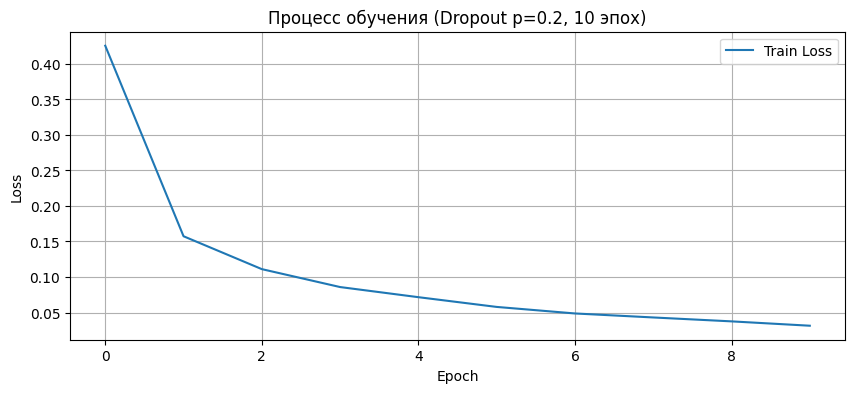

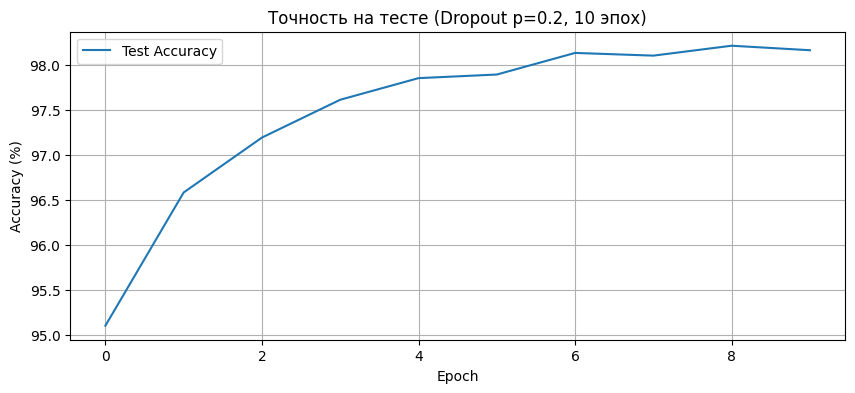

In [ ]:
# ============================================================
# Финальная модель (Dropout p=0.2, lr=0.01, 10 эпох)
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np, random, time, matplotlib.pyplot as plt

# -----------------------------
# 1. Seed
# -----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(42)

# -----------------------------
# 2. Данные
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST("data", train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

# -----------------------------
# 3. Модель
# -----------------------------
class FinalDropoutModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(512, 512)
        self.drop2 = nn.Dropout(p)
        self.fc3 = nn.Linear(512, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)

# -----------------------------
# 4. Обучение
# -----------------------------
def train_and_eval(model, lr=0.01, momentum=0.9, epochs=10):
    device = torch.device("cpu")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_loss, test_acc = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss.append(total_loss / len(train_loader))

        # тест
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = 100 * correct / total
        test_acc.append(acc)
        print(f"Epoch {epoch+1:02d}/{epochs} | TrainLoss={train_loss[-1]:.4f} | TestAcc={acc:.2f}%")
    return train_loss, test_acc

# -----------------------------
# 5. Запуск
# -----------------------------
print("🚀 Обучаем модель (Dropout p=0.2, lr=0.01, 10 эпох)...")
model = FinalDropoutModel(p=0.2)
start = time.time()
loss, acc = train_and_eval(model, lr=0.01, epochs=10)
elapsed = time.time() - start
print(f"\n✅ Финальная точность: {max(acc):.2f}% | Время обучения: {elapsed:.1f} сек.")

# -----------------------------
# 6. Визуализация
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(loss, label="Train Loss")
plt.title("Процесс обучения (Dropout p=0.2, 10 эпох)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(acc, label="Test Accuracy")
plt.title("Точность на тесте (Dropout p=0.2, 10 эпох)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.legend()
plt.show()


🚀 Обучаем модель Dropout + L2 (p=0.2, lr=0.01, weight_decay=1e-4)
Epoch 01/10 | TrainLoss=0.4257 | TestAcc=94.99%
Epoch 02/10 | TrainLoss=0.1578 | TestAcc=96.62%
Epoch 03/10 | TrainLoss=0.1116 | TestAcc=97.12%
Epoch 04/10 | TrainLoss=0.0865 | TestAcc=97.58%
Epoch 05/10 | TrainLoss=0.0722 | TestAcc=97.77%
Epoch 06/10 | TrainLoss=0.0588 | TestAcc=97.91%
Epoch 07/10 | TrainLoss=0.0495 | TestAcc=98.07%
Epoch 08/10 | TrainLoss=0.0440 | TestAcc=98.10%
Epoch 09/10 | TrainLoss=0.0386 | TestAcc=98.11%
Epoch 10/10 | TrainLoss=0.0326 | TestAcc=98.14%

✅ Финальная точность: 98.14% | Время обучения: 234.7 сек.


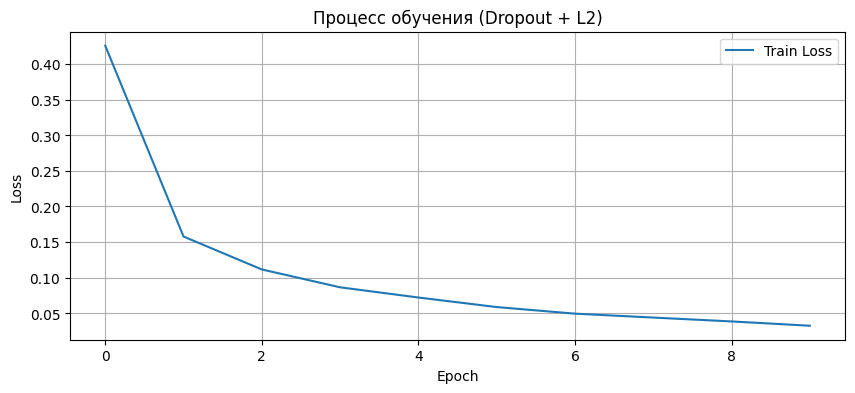

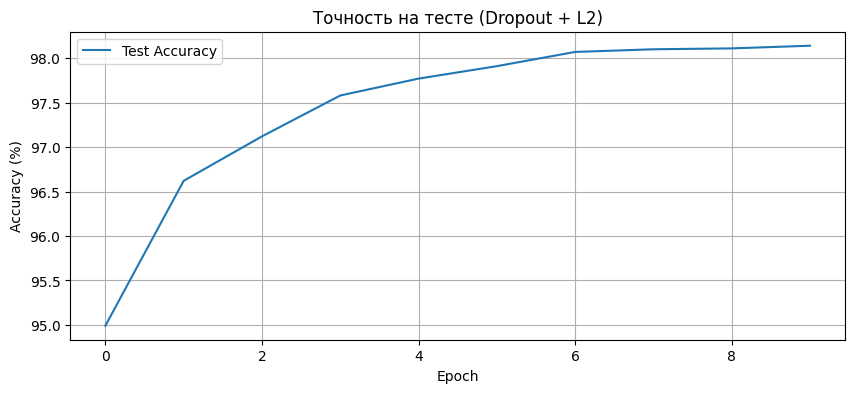

In [ ]:
# ============================================================
# Модель Dropout + L2 regularization (p=0.2, lr=0.01, weight_decay=1e-4)
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np, random, time, matplotlib.pyplot as plt

# -----------------------------
# 1. Seed
# -----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(42)

# -----------------------------
# 2. Данные
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data = datasets.MNIST("data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST("data", train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

# -----------------------------
# 3. Модель
# -----------------------------
class DropoutL2Net(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(512, 512)
        self.drop2 = nn.Dropout(p)
        self.fc3 = nn.Linear(512, 10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)

# -----------------------------
# 4. Обучение
# -----------------------------
def train_and_eval(model, lr=0.01, momentum=0.9, l2_weight=1e-4, epochs=10):
    device = torch.device("cpu")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=l2_weight)
    criterion = nn.CrossEntropyLoss()

    train_loss, test_acc = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss.append(total_loss / len(train_loader))

        # --- Тест ---
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                pred = model(X).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = 100 * correct / total
        test_acc.append(acc)
        print(f"Epoch {epoch+1:02d}/{epochs} | TrainLoss={train_loss[-1]:.4f} | TestAcc={acc:.2f}%")
    return train_loss, test_acc

# -----------------------------
# 5. Запуск
# -----------------------------
print("🚀 Обучаем модель Dropout + L2 (p=0.2, lr=0.01, weight_decay=1e-4)")
model = DropoutL2Net(p=0.2)
start = time.time()
loss, acc = train_and_eval(model, lr=0.01, l2_weight=1e-4, epochs=10)
elapsed = time.time() - start
print(f"\n✅ Финальная точность: {max(acc):.2f}% | Время обучения: {elapsed:.1f} сек.")

# -----------------------------
# 6. Визуализация
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(loss, label="Train Loss")
plt.title("Процесс обучения (Dropout + L2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(acc, label="Test Accuracy")
plt.title("Точность на тесте (Dropout + L2)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.legend()
plt.show()
